In [1]:
import sys
sys.path.append("..")

import pandas as pd
from reader import generic_reader
from inflation import read_cpi_by_year, convert_usd




In [2]:
cpi_by_year = read_cpi_by_year("inflation_data/cpiai.csv")
# cpi_by_year
convert_usd(1000, 2000, 2023, cpi_by_year)

1769

In [3]:
df_movies = generic_reader.read_csv_file_to_data_frame("../movie_data/movies.csv")
df_movies.info()
df_movies.sort_values(by="budget", ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801 entries, 0 to 2800
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   2801 non-null   bool   
 1   backdrop_path           2800 non-null   object 
 2   budget                  2801 non-null   int64  
 3   homepage                1902 non-null   object 
 4   movie_id                2801 non-null   int64  
 5   imdb_id                 2800 non-null   object 
 6   origin_country          2801 non-null   object 
 7   original_language       2801 non-null   object 
 8   original_title          2801 non-null   object 
 9   overview                2801 non-null   object 
 10  popularity              2801 non-null   float64
 11  poster_path             2800 non-null   object 
 12  production_countries    2801 non-null   object 
 13  release_date            2801 non-null   object 
 14  revenue                 2801 non-null   

,adult,backdrop_path,budget,homepage,movie_id,imdb_id,origin_country,original_language,original_title,overview,...,vote_average,vote_count,director_person_ids,genre_ids,production_company_ids,collection_id,cast_person_ids,cast_credit_ids,crew_person_ids,crew_credit_ids
2646,False,/698FjyzLdpgXmUSr63LaRwblTmx.jpg,583900000,https://www.jurassicworld.com,507086,tt8041270,['US'],en,Jurassic World Dominion,"Four years after Isla Nublar was destroyed, di...",...,6.634,6669,[930707],"[12, 28, 878]","[56, 33]",328.0,"[73457, 18997, 4784, 4783, 4785, 206425, 16398...","['5b30ddfbc3a36853140012e7', '5b30de25c3a36853...","[1546026, 1084741, 3169987, 2825529, 491, 9307...","['607745d9fbe36f0042882c44', '607745c318864b00..."
2392,False,/SPkEiZGxq5aHWQ2Zw7AITwSEo2.jpg,416000000,https://www.starwars.com/films/star-wars-episo...,181812,tt2527338,['US'],en,Star Wars: The Rise of Skywalker,The surviving Resistance faces the First Order...,...,6.283,10364,[15344],"[12, 28, 878]","[1, 11461]",10.0,"[4, 2, 1315036, 1023139, 236695, 25072, 6, 153...","['5e867292e375c000143de939', '5e8671e404b59600...","[3084035, 3508489, 3555057, 2825529, 1110521, ...","['60997cee87e63e003b6b9811', '628726963d745400..."
1132,False,/uzIGtyS6bbnJzGsPL93WCF1FWm8.jpg,379000000,https://movies.disney.com/pirates-of-the-carib...,1865,tt1298650,"['US', 'GB']",en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,...,6.561,14499,[17633],"[12, 28, 14]","[2, 130, 20478]",295.0,"[85, 955, 118, 6972, 2449, 237455, 469759, 111...","['52fe431cc3a36847f803af13', '52fe431cc3a36847...","[770, 17633, 947, 1705, 1706, 406204, 1526463,...","['52fe431cc3a36847f803aedf', '52fe431cc3a36847..."
1663,False,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,365000000,https://www.marvel.com/movies/avengers-age-of-...,99861,tt2395427,['US'],en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,...,7.300,23738,[12891],"[28, 12, 878]",[420],86311.0,"[3223, 74568, 103, 16828, 1245, 17604, 13548, ...","['55e256d292514162cd000e40', '52fe4a449251416c...","[608, 12891, 12891, 10850, 113675, 7624, 30306...","['60b188428ee49c006dc57b28', '52fe4a449251416c..."
2286,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,356000000,https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,['US'],en,Avengers: Endgame,After the devastating events of Avengers: Infi...,...,8.238,26765,"[19272, 19271]","[12, 878, 28]",[420],86311.0,"[3223, 16828, 103, 74568, 1245, 17604, 16851, ...","['5e85cd735294e700134abf26', '5e85cd84691cd500...","[3019687, 57027, 3064294, 3062791, 4230717, 27...","['6057fbdf8c44b90054683688', '606f5c67dff66e00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,False,/AwB7HGeDTrBGkP2WEnNwg8Wa0E4.jpg,0,https://www.netflix.com/title/81212842,638974,tt15255288,['US'],en,Murder Mystery 2,"After starting their own detective agency, Nic...",...,6.402,1836,[59027],"[9648, 35, 80]","[878, 7382, 19367, 1205, 3574]",929336.0,"[19292, 4491, 2983, 19119, 1695989, 51878, 184...","['614fefb71c635b002a0d54ff', '614fefbfa5d84900...","[11699, 24529, 59027, 2161377, 162577, 102595,...","['6293f5f5fd630000663d1ea6', '650d09042c6b7b00..."
2730,False,/T5xXoFqyc9jNXZIbH4Sw0jwWjw.jpg,0,NaN,605886,tt10275534,['US'],en,To Catch a Killer,Baltimore. New Year's Eve. A talented but trou...,...,6.880,1189,[591600],"[53, 80, 18]","[7493, 106786]",NaN,"[94185, 77335, 1607522, 202032, 129419, 84832,...","['5cf066df92514169fdba1b82', '5fda1e35a3770a00...","[1020046, 2226015, 1486817, 1646476, 34338, 20...","['604e392fed96bc0029479ad7', '63f60de07dfda600..."
1712,False,/mLg1I7Nn47CYOdG1tOXegOhcayQ.jpg,0,NaN,339527,tt1291570,['US'],en,Solace,"A psychic doctor, John Clancy, works with an F...",...,6.421,2294,[1032011],"[53, 80, 9648]","[20313, 3604, 85885, 2273, 7493, 34081, 12075,...",NaN,"[4173, 47296, 37260, 72466, 98215, 20191, 6407...","['554e67fcc3a3681870002645', '55763788c3a36824...","[1407724, 1748851, 6898, 1399877, 2091399, 193...","

In [4]:
columns_to_keep = ['movie_id', 'original_title', 'release_date', 'budget', 'revenue']
df_movies = df_movies[columns_to_keep].copy()
df_movies

,movie_id,original_title,release_date,budget,revenue
0,49948,Fantasia 2000,2000-01-01,80000000,60655420
1,10898,The Little Mermaid II: Return to the Sea,2000-01-23,0,0
2,4234,Scream 3,2000-02-04,40000000,161834276
3,2787,Pitch Black,2000-02-18,23000000,53187659
4,2069,The Whole Nine Yards,2000-02-18,41300000,106371651
...,...,...,...,...,...
2796,848326,Rebel Moon - Part One: A Child of Fire,2023-12-15,83000000,0
2797,467244,The Zone of Interest,2023-12-15,15000000,52631884
2798,572802,Aquaman and the Lost Kingdom,2023-12-20,205000000,440181226
2799,1072790,Anyone But You,2023-12-21,25000000,214891370


In [5]:
df_movies = df_movies[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)].copy()

In [6]:
# Convert release_data into proper datetime objects
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])

# Create year column
df_movies['release_year'] = df_movies['release_date'].dt.year

In [7]:
# Convert budget to 2023 USD
df_movies['budget_2023_usd'] = df_movies.apply(
    lambda row: convert_usd(
        original_amount=row['budget'],
        original_year=row['release_year'],
        new_year=2023,
        cpi_by_year=cpi_by_year
    ),
    axis=1
)

# Convert revenue to 2023 USD
df_movies['revenue_2023_usd'] = df_movies.apply(
    lambda row: convert_usd(
        original_amount=row['revenue'],
        original_year=row['release_year'],
        new_year=2023,
        cpi_by_year=cpi_by_year
    ),
    axis=1
)

In [8]:
df_movies
df_movies.sort_values(by="budget_2023_usd", ascending=False)

,movie_id,original_title,release_date,budget,revenue,release_year,budget_2023_usd,revenue_2023_usd
2646,507086,Jurassic World Dominion,2022-06-01,583900000,1004004592,2022,607935300,1045332818
1132,1865,Pirates of the Caribbean: On Stranger Tides,2011-05-15,379000000,1046721266,2011,513391695,1417883919
2392,181812,Star Wars: The Rise of Skywalker,2019-12-18,416000000,1074144248,2019,495803565,1280203240
1663,99861,Avengers: Age of Ultron,2015-04-22,365000000,1405403694,2015,469232494,1806742684
651,285,Pirates of the Caribbean: At World's End,2007-05-19,300000000,961691209,2007,440867221,1413260435
...,...,...,...,...,...,...,...,...
1450,220289,Coherence,2013-09-19,50000,139745,2013,65399,182783
2089,420634,Terrifier,2018-01-25,35000,421798,2018,42470,511824
688,23827,Paranormal Activity,2007-09-14,15000,193355800,2007,22043,284147447
382,14337,Primer,2004-10-08,7000,545436,2004,11292,879883


Calculate profit and ROI

In [9]:
df_movies['profit_2023_usd'] = df_movies['revenue_2023_usd'] - df_movies['budget_2023_usd']
df_movies['roi'] = ( df_movies['profit_2023_usd'] / df_movies['budget_2023_usd'] )*100
df_movies.sort_values(by="profit_2023_usd", ascending=False)

,movie_id,original_title,release_date,budget,revenue,release_year,budget_2023_usd,revenue_2023_usd,profit_2023_usd,roi
956,19995,Avatar,2009-12-15,237000000,2923706026,2009,336605225,4152467198,3815861973,1133.631236
2286,299534,Avengers: Endgame,2019-04-24,356000000,2799439100,2019,424293436,3336470881,2912177445,686.359297
1758,140607,Star Wars: The Force Awakens,2015-12-15,245000000,2068223624,2015,314964276,2658843091,2343878815,744.172909
2126,299536,Avengers: Infinity War,2018-04-25,300000000,2052415039,2018,364030217,2490470306,2126440089,584.138346
2707,76600,Avatar: The Way of Water,2022-12-14,350000000,2320250281,2022,364407184,2415759634,2051352450,562.928652
...,...,...,...,...,...,...,...,...,...,...
2780,800158,The Killer,2023-10-25,175000000,362113,2023,175000000,362113,-174637887,-99.793078
2592,512195,Red Notice,2021-11-04,160000000,178143,2021,179917697,200319,-179717378,-99.888661
2372,398978,The Irishman,2019-11-01,159000000,968853,2019,189501843,1154713,-188347130,-99.390659
2656,725201,The Gray Man,2022-07-13,200000000,454023,2022,208232677,472712,-207759965,-99.772989


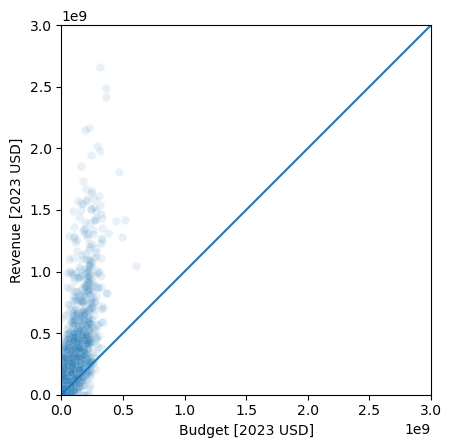

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['revenue_2023_usd'], alpha=0.1)
plt.xlim(0, 3e9)
plt.ylim(0, 3e9)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Revenue [2023 USD]");

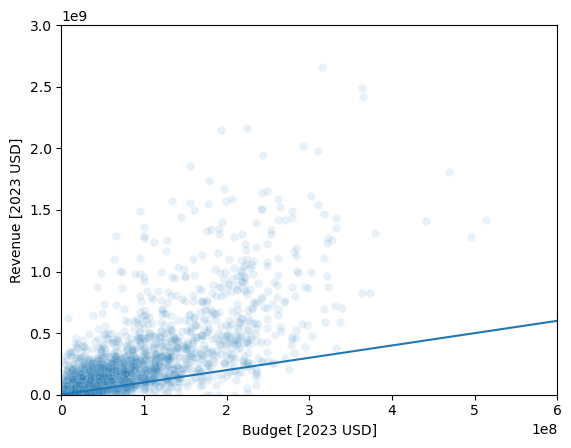

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['revenue_2023_usd'], alpha=0.1)
plt.xlim(0, 0.6e9)
plt.ylim(0, 3e9)
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Revenue [2023 USD]");

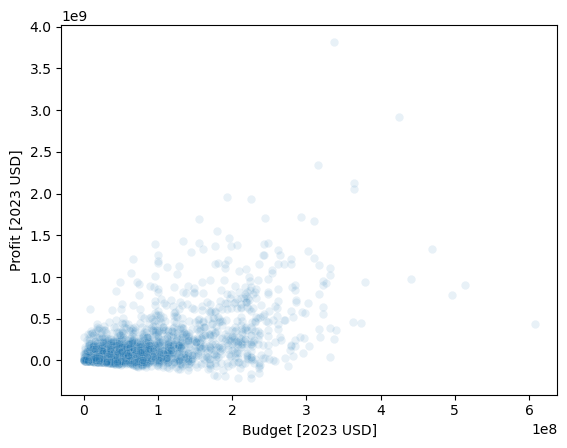

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['profit_2023_usd'], alpha=0.1)
# plt.xlim(0, 0.6e9)
# plt.ylim(0, 3e9)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Profit [2023 USD]");